In [174]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import cv2
import tools
from mpl_toolkits.mplot3d import Axes3D
import pickle
import time
import glob
import os
#%matplotlib

### Kamere

In [175]:
def cv_project_points(X, Rt, K, distCoeffs=None):
    """
    Project points X from world coordinate frame into image plane.
    Uses cv2.pojectPoints()
    x = PX (H&Z, p. 156)
    
    Parameters
    ----------
    X : ndarray of shape(N, 3) containing thw world coordinates of N points
    Rt : ndarray of shape (3, 4) camera projection matrix in normalized coordinates
    K : ndarray of shape (3, 3), camera intrinsic matrix
    distCoeffs : ndarray of shape (n ,1) of camera distortion coefficients
    """
    
    if distCoeffs is None:
        distCoeffs = np.zeros((4, 1), dtype=np.float64)
    
    rvec = cv2.Rodrigues(Rt[:, :3])[0]
    tvec = Rt[:, 3]
    x = cv2.projectPoints(X.astype(np.float64), rvec.astype(np.float64), tvec.astype(np.float64), K, distCoeffs)[0]
    return np.squeeze(np.rollaxis(x, 2, 1))

In [176]:
def project_points(X, Rt, K, normalize=True):
    """
    Project points X from world coordinate frame into image plane.
    x = PX (H&Z, p. 156)
    
    Parameters
    ----------
    X : ndarray of shape(N, 3) containing the world coordinates of N points
    Rt : ndarray of shape (3, 4) camera projection matrix in normalized coordinates
    K : ndarray of shape (3, 3), camera intrinsic matrix
    """
    X_h = np.vstack((X.T, np.ones(X.shape[0])))
    P = np.dot(K, Rt) * 5
    x_h = np.dot(P, X_h)
    if normalize:
        x = x_h[:2, :] / x_h[2]
    else:
        x = x_h
    return np.transpose(x)

In [177]:
N_cams = 5
r = 500
max_angle = np.pi/2
axis = np.array([0, 1, 0], dtype=float)
angles = -np.linspace(0, max_angle, N_cams)
Cs = np.column_stack((np.cos(-angles-np.pi/2), np.zeros(N_cams), 1+np.sin(-angles-np.pi/2))) * r

In [178]:
K = np.eye(3, dtype=np.float64)
K[0, 0] = 10.
K[1, 1] = 10.

In [179]:
path_calib = 'kalibracija/redmi'
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)

In [180]:
Rs = [cv2.Rodrigues(angle*axis)[0].T for angle in angles]
ts = np.array([-np.dot(Rs[i], Cs[i]) for i in range(N_cams)])
Ps = [np.column_stack((Rs[i], ts[i])) for i in range(N_cams)]

In [181]:
Xs, Ys, Zs = np.array([tools.pos_from_Rt(Rt) for Rt in Ps]).T
Xd, Yd, Zd = np.column_stack([R[2] for R in Rs])

In [182]:
R = np.linspace(0, 1., N_cams)
G = np.linspace(0.5, 1., N_cams)
B = R[::-1]
c_colors = np.column_stack((R, G, B))

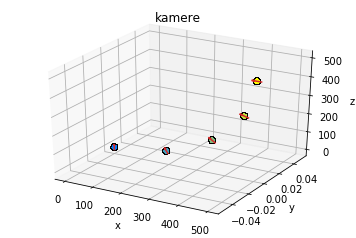

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs, Ys, Zs, Xd, Yd, Zd, color='C3', length=35, normalize=True, pivot='middle')
ax.scatter(Xs, Ys, Zs, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere')
plt.show()

### Točke

In [184]:
N_points = 200
rand_amp = r / 20
r_t = r//4

phi = np.linspace(np.pi/3, 2*np.pi/3, int(N_points**(1/2)))
theta = np.linspace(np.pi/4, 5*np.pi/4, int(N_points**(1/2)))

phi = np.linspace(0, 2*np.pi, int(N_points**(1/2)))
theta = np.linspace(0, np.pi, int(N_points**(1/2)))

kx, ky = np.meshgrid(theta, phi)
XX = r_t * np.cos(kx) * np.sin(ky)
ZZ = r_t * np.sin(kx) * np.sin(ky)  + r
YY = r_t * np.cos(ky)

In [185]:
XX = XX + np.random.randn(*XX.shape) * rand_amp - np.random.rand(1) * r_t
YY = YY + np.random.randn(*YY.shape) * rand_amp - np.random.rand(1) * r_t
ZZ = ZZ + np.random.randn(*ZZ.shape) * rand_amp - np.random.rand(1) * r_t

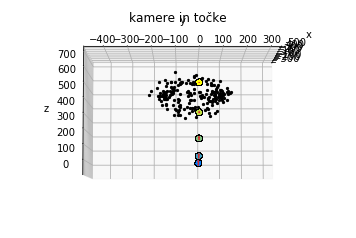

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs, Ys, Zs, Xd, Yd, Zd, color='C3', length=35, normalize=True, pivot='middle')
ax.scatter(Xs, Ys, Zs, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)

ax.scatter(XX, YY, ZZ, c='k', marker='.', depthshade=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere in točke')

#bounding box (equal spect ratio)
X_max = np.max([Xs.max(), XX.max()])
Y_min = np.min([Xs.min(), XX.min()])
Y_max = np.max([Ys.max(), YY.max()])
X_min = np.min([Ys.min(), YY.min()])
Z_max = np.max([Zs.max(), ZZ.max()])
Z_min = np.min([Zs.min(), ZZ.min()])

max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_max+X_min)
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_max+Y_min)
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_max+Z_min)
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

for angle in range(-90, 0, 5):
    ax.view_init(angle, 0)
    plt.draw()
    plt.pause(0.01)
    
plt.show()

In [187]:
XYZ = np.column_stack((XX.ravel(), YY.ravel(), ZZ.ravel()))

In [188]:
#%%timeit
xyz_cv = [cv_project_points(XYZ, Rt, K) for Rt in Ps]

In [189]:
#%%timeit
xyz = [project_points(XYZ, Rt, K) for Rt in Ps]

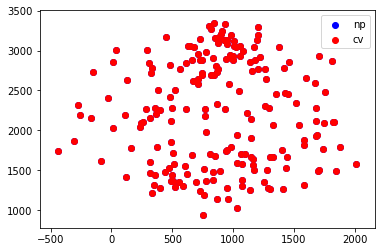

In [190]:
plt.figure()
plt.scatter(xyz[1][:, 0], xyz[1][:, 1], c='b', label='np')
plt.scatter(xyz_cv[1][:, 0], xyz_cv[1][:, 1], c='r', label='cv')
plt.legend()
plt.show()

#### Triangulation test

In [197]:
triangulation = tools.triangulate_lm
#triangulation = tools.triangulate_lsq

In [198]:
x_0 = xyz[0]
x_1 = xyz[1]
X_triangulated = np.column_stack([triangulation(tools.to_homogenous(p0), tools.to_homogenous(p1), Ps[0], Ps[1], K) for p0, p1 in zip(x_0, x_1)])
X_triangulated = X_triangulated[:3] / X_triangulated[3]
X_triangulated.shape

(3, 196)

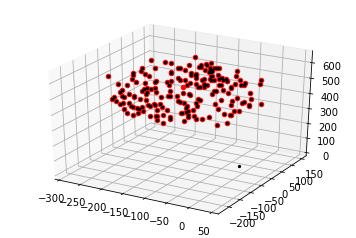

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X_t, Y_t, Z_t = X_triangulated
#ax.scatter(X_t, Y_t, Z_t, c='k', antialiased=False, depthshade=False, marker='.')

ax.scatter(XX, YY, ZZ, c='r', antialiased=False, depthshade=False, marker='o')
ax.scatter(X_t, Y_t, Z_t, c='k', antialiased=False, depthshade=False, marker='.')
plt.show()

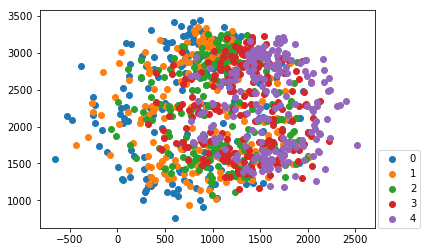

In [210]:
x = xyz_cv
plt.figure()
for i in range(N_cams):
    plt.scatter(x[i][:, 0], x[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i))
plt.legend(loc=(1.01, 0))
plt.show()

### Naključne točke iz prvih nekaj kamer:

pikazane točke [119  16 115 156  91]


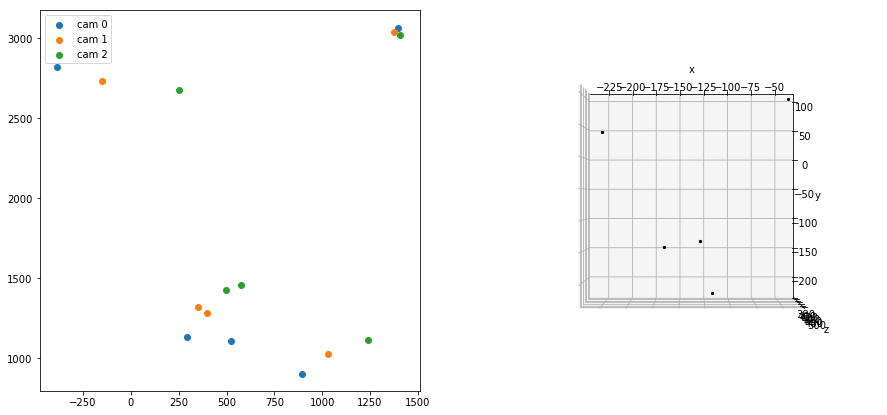

In [211]:
ncams = 3
npoints = 5
pointind = np.random.choice(np.arange(N_points-N_points//10), npoints)
print('pikazane točke {}'.format(pointind))

fig = plt.figure(figsize=(15, 7))
for i in range(ncams):
    cam = i
    ax_p = fig.add_subplot(1, 2, 1)
    ax_p.scatter(xyz[cam][pointind, 0], xyz[i][pointind, 1], c='C{:d}'.format(i), label='cam {:d}'.format(cam))
ax_p.legend()
    
ax_3d = fig.add_subplot(1, 2, 2, projection='3d')
ax_3d.scatter(XYZ[pointind, 0], XYZ[pointind, 1], XYZ[pointind, 2], c='k', marker='.', depthshade=False)
ax_3d.set_xlabel('x')
ax_3d.set_ylabel('y')
ax_3d.set_zlabel('z')
ax_3d.view_init(90, 270)

plt.show()

In [246]:
def get_camera_matrices(p1, p2, K, P1=None, d_max=1, alpha=0.995):
    """
    Camera matrix estimation from known point correspondances.
    P = [R|t] ... normalized camera matrix; P1 = [I|0] (H&Z, p. 257)
    Uses Levenberg–Marquardt optimization to to minimize reprojection error.
    """
    
    if P1 is None:
        P1 = np.column_stack((np.eye(3), np.zeros(3)))
    
    #F, mask = cv2.findFundamentalMat(p1, p2, cv2.FM_8POINT, d_max, alpha)
    F, p1, p2 = tools.get_fundamental_matrix(p1, p2, K)
    
    p2_h = np.column_stack((p2, np.ones(p2.shape[0])))
    p1_h = np.column_stack((p1, np.ones(p1.shape[0])))
    
    # essential matrix (H&Z, p. 257)
    E = np.dot(K.T, F).dot(K)
    U, D, VT = np.linalg.svd(E) # np.linalg.svd -> U, D, V.T

    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]], dtype=float)
    
    u3 = U[:, -1]
    R1 = U.dot(W).dot(VT)
    R2 = U.dot(W.T).dot(VT)
    #positive determinants
    R1 = R1 * np.sign(np.linalg.det(R1))
    R2 = R2 * np.sign(np.linalg.det(R2)) 
    
    # four possibilities for the second camera matrix P2 (H&Z, p. 259)
    P1_4 = np.vstack((P1, np.array([0, 0, 0, 1])))
    P2_1 = np.dot(np.column_stack((R1, u3)), P1_4)
    P2_2 = np.dot(np.column_stack((R1, -u3)), P1_4)
    P2_3 = np.dot(np.column_stack((R2, u3)), P1_4)
    P2_4 = np.dot(np.column_stack((R2, -u3)), P1_4)
    P2_list = [P2_1, P2_2, P2_3, P2_4]
    
    # test points to determine if projections are in front of both cameras
    tally = np.zeros(4)
    for i, P2 in enumerate(P2_list):
        for x1, x2 in zip(p1[:10], p2[:10]):
            X = tools.triangulate_lm(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2, K)
            if tools.in_front(X, P2) and tools.in_front(X, P1):
                tally[i] += 1
                
    P2 = P2_list[np.argmax(tally)]
    #P2_new = P2
    p1_h = np.column_stack((p1, np.ones(p1.shape[0])))
    p2_h = np.column_stack((p2, np.ones(p2.shape[0])))
    
    x0 = np.hstack((cv2.Rodrigues(P2[:, :3])[0][:,0], P2[:, 3]))
    args = (p1_h, p2_h, K)
    res = least_squares(tools.first_camera_reprojection_error, x0=x0, method='lm', 
                        ftol=1e-13, xtol=1e-15, max_nfev=500, verbose=1, args=args)
    
    rvec_tvec = res.x
    rvec = rvec_tvec[:3].copy()
    tvec = rvec_tvec[3:].copy()
    R_new = cv2.Rodrigues(rvec)[0]
    P2_new = np.column_stack((R_new, tvec))
    
    return P1, P2_new / P2_new[-1, -1]

In [213]:
def get_camera_matrices_PnP(p2, K, X, d_max=1, alpha=0.995, RANSAC=True, initial_Rt=None):
    """
    PnP camera estimation using known point correspondances and 3D positions.
    P = [R|t] ... normalized camera matrix; P1 = [I|0] (H&Z, p. 257)
    """
    
    if initial_Rt is not None:
        ext_guess = 1
        i_rvec = cv2.Rodrigues(initial_Rt[:, :-1])[0]
        i_tvec = initial_Rt[:, -1]
    else:
        ext_guess = 0
        i_rvec = np.zeros(3)
        i_tvec = np.zeros(3)
    
    X = X.astype(np.float64)
    p2 = p2.astype(np.float64)
    if RANSAC:
        retval, rvec, tvec, mask = cv2.solvePnPRansac(X, p2, cameraMatrix=K, distCoeffs=np.zeros(8), 
                                                      rvec=i_rvec, tvec=i_tvec, useExtrinsicGuess=ext_guess)
    else:
        retval, rvec, tvec = cv2.solvePnP(X, p2, cameraMatrix=K, distCoeffs=np.zeros(4), 
                                                      rvec=i_rvec, tvec=i_tvec, useExtrinsicGuess=ext_guess)

    R2 = cv2.Rodrigues(rvec)[0]
    P2 = np.column_stack((R2, tvec))

    return P2

#### F pose estimation

------------------

H&Z, p. 257

In [240]:
def first_camera_reprojection_error(par, p1, p2, K, P1=None):
    
    rvec = par[:3]
    tvec = par[3:]
    R = cv2.Rodrigues(rvec)[0]
    Rt = np.column_stack((R, tvec))
    P2 = K.dot(Rt)

    if P1 is None:
        P1 = np.column_stack((np.eye(3), np.zeros(3)))
    
    X = np.column_stack([tools.triangulate_lm(x1, x2, P1, P2) for x1, x2 in zip(p1[:50], p2[:50])])
    reprojected_x_h = np.dot(P2, X)
    reprojected_x = reprojected_x_h[:2] / reprojected_x_h[2]
    image_points = p2.T[:2, :50]
    diff = reprojected_x - image_points
    return diff.ravel()

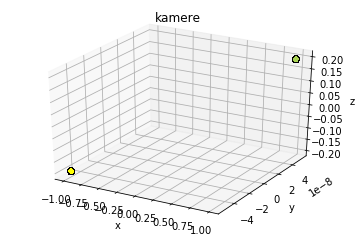

[ 0.  0.  9.  1.]
`xtol` termination condition is satisfied.
Function evaluations 53, initial cost 4.1099e+05, final cost 3.6593e+05, first-order optimality 7.01e+09.


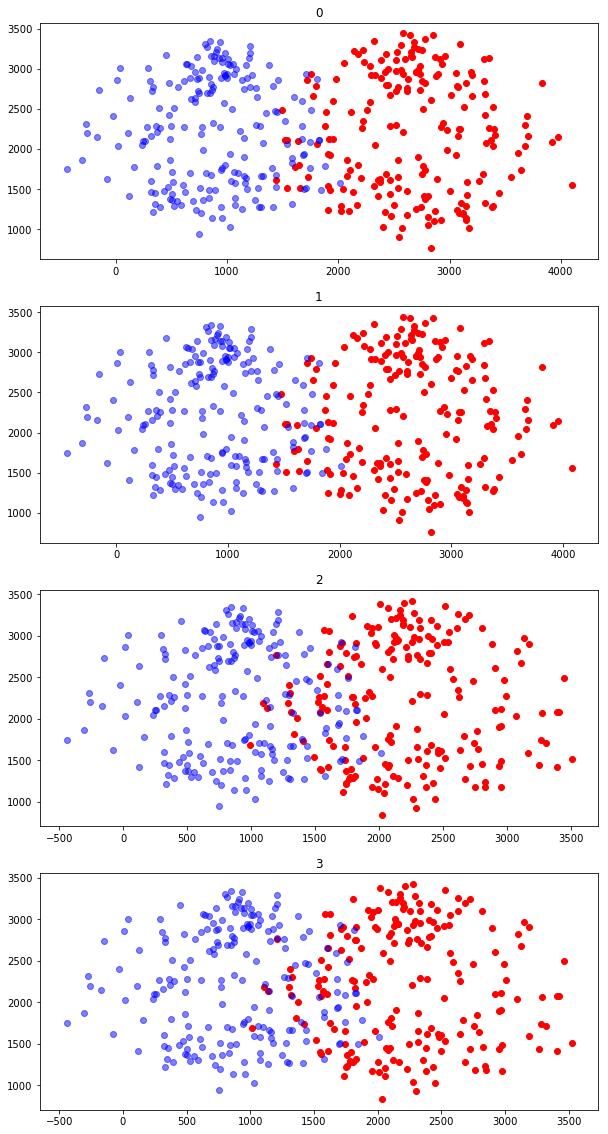

In [241]:
novi_P =[]
for i in range(1, 2):

    P1 = Ps[0]
    P2 = Ps[i]
    x1 = xyz[0]
    x2 = xyz[i]
    

    F, mask = cv2.findFundamentalMat(x1, x2, cv2.FM_8POINT)
    
    E = K.T.dot(F).dot(K)
    u, d, vt = np.linalg.svd(E)

    x1_h = np.column_stack((x1, np.ones(x1.shape[0])))
    x2_h = np.column_stack((x2, np.ones(x2.shape[0])))

    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]], dtype=float)

    u3 = u[:, -1]
    R1 = u.dot(W).dot(vt)
    R2 = u.dot(W.T).dot(vt)
    #positive determinants
    R1 = R1 * np.sign(np.linalg.det(R1))
    R2 = R2 * np.sign(np.linalg.det(R2)) 

    # four possibilities for the second camera matrix P2 (H&Z, p. 259)
    P1_4 = np.vstack((P1, np.array([0, 0, 0, 1])))
    P2_1 = np.dot(np.column_stack((R1, u3)), P1_4)
    P2_2 = np.dot(np.column_stack((R1, -u3)), P1_4)
    P2_3 = np.dot(np.column_stack((R2, u3)), P1_4)
    P2_4 = np.dot(np.column_stack((R2, -u3)), P1_4)
    P2_list = [P2_1, P2_2, P2_3, P2_4]

    X2, Y2, Z2 = np.array([tools.pos_from_Rt(Rt) for Rt in P2_list]).T

    R = np.linspace(0, 1., len(P2_list))
    G = np.linspace(0.5, 1., (len(P2_list)))
    B = R[::-1]
    c_colors = np.column_stack((R, G, B))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(X2, Y2, Z2, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('kamere')
    plt.show()

    xyz_P2 = [project_points(XYZ, Rt, K) for Rt in P2_list]

    tally = np.zeros(4)
    for i, P2 in enumerate(P2_list):
        for t1, t2 in zip(x1[:10], x2[:10]):
            X = tools.triangulate_lm(tools.to_homogenous(t1), tools.to_homogenous(t2), P1, P2, K)
            if tools.in_front(X, P2) and tools.in_front(X, P1):
                tally[i] += 1
    
    P2 = P2_list[np.argmax(tally)]
    print(tally)
    
    x0 = np.hstack((cv2.Rodrigues(P2[:, :3])[0][:,0], P2[:, 3]))
    args = (x1_h, x2_h, K)
    res = least_squares(first_camera_reprojection_error, x0=x0, method='lm', 
                        ftol=1e-13, xtol=1e-15, max_nfev=2000, verbose=1, args=args)
    rvec_tvec = res.x
    rvec = rvec_tvec[:3].copy()
    tvec = rvec_tvec[3:].copy()
    R_new = cv2.Rodrigues(rvec)[0]
    P2_new = np.column_stack((R_new, tvec))

    fig, ax = plt.subplots(4,1, figsize=(10, 20))
    for i in range(len(P2_list)):
        ax[i].scatter(xyz_P2[i][:, 0], xyz_P2[i][:, 1], c='r')
        ax[i].scatter(xyz[1][:, 0], xyz[1][:, 1], c='b', alpha=0.5)
        ax[i].set_title('{:d}'.format(i))
    plt.show()

    novi_P.append(P2_new / P2_new[-1, -1])

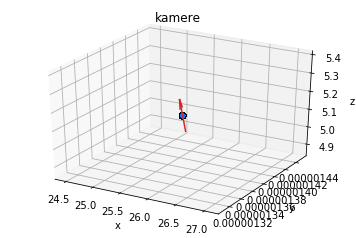

25.769212184 1.38061229554e-06 5.12580676571


In [242]:
Xf, Yf, Zf = np.array([tools.pos_from_Rt(Rt) for Rt in novi_P]).T
Xfd, Yfd, Zfd = np.column_stack([R[2, :-1] for R in novi_P])

R = np.linspace(0, 1., len(P2_list))
G = np.linspace(0.5, 1., (len(P2_list)))
B = R[::-1]
c_colors = np.column_stack((R, G, B))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xf, Yf, Zf, Xfd, Yfd, Zfd, color='C3', length=0.2, normalize=True, pivot='middle')
ax.scatter(Xf, Yf, Zf, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere')
plt.show()
print(Xf[0], Yf[0], Zf[0])

In [244]:
xyz_new = [project_points(XYZ, Rt, K) for Rt in novi_P]

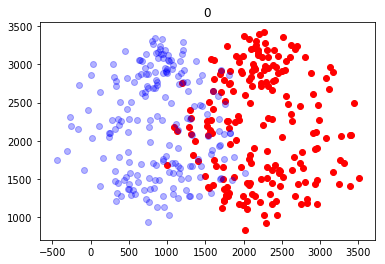

In [245]:
fig, ax = plt.subplots(len(xyz_new),1)
for i in range(len(novi_P)):
    if len(xyz_new) == 1:
        axis = ax
    else:
        axis = ax[i]
    axis.scatter(xyz_new[i][:, 0], xyz_new[i][:, 1], c='r')
    axis.scatter(xyz[1][:, 0], xyz[1][:, 1], c='b', alpha=0.3)
    axis.set_title('{:d}'.format(i))
plt.show()

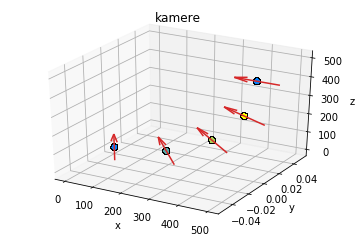

191.341716183 0.0 38.0602337444


In [220]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs, Ys, Zs, Xd, Yd, Zd, color='C3', length=150, normalize=True, pivot='middle')
ax.scatter(Xs, Ys, Zs, c=c_colors, antialiased=False, depthshade=False, edgecolor='k', linewidth=0.01, s=50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('kamere')
plt.show()
print(Xs[1], Ys[1], Zs[1])

-------------

In [247]:
P_reconstructed = [np.column_stack((np.eye(3), np.zeros(3)))]
for i in range(N_cams - 1):
    p1, p2 = xyz[i].astype(np.float64), xyz[i+1].astype(np.float64)
    P1, P2 = get_camera_matrices(p1, p2, K, P1=P_reconstructed[i])
    P_reconstructed.append(P2)

`xtol` termination condition is satisfied.
Function evaluations 25, initial cost 3.8522e+05, final cost 3.7671e+05, first-order optimality 5.65e+09.
`xtol` termination condition is satisfied.
Function evaluations 24, initial cost 6.7512e+05, final cost 5.7197e+05, first-order optimality 7.27e+09.
`xtol` termination condition is satisfied.
Function evaluations 14, initial cost 1.1496e+06, final cost 1.1496e+06, first-order optimality 9.57e+10.
`xtol` termination condition is satisfied.
Function evaluations 16, initial cost 2.4437e+06, final cost 2.4437e+06, first-order optimality 9.65e+10.


#### PnP Pose estimation

In [222]:
P_reconstructed_PnP = [np.column_stack((np.eye(3), np.zeros(3)))]
for i in range(N_cams - 1):
    p2 = xyz[i+1]
    P2 = get_camera_matrices_PnP(p2, K, XYZ, RANSAC=False, initial_Rt=None)
    P_reconstructed_PnP.append(P2)

## Prikaz

In [223]:
izpis = False
P_za_prikaz = P_reconstructed_PnP
P_za_prikaz = P_reconstructed

In [224]:
if izpis:
    np.set_printoptions(precision=2)
    print('\nRECONSTRUCTED')
    for i, _ in enumerate(P_za_prikaz):
        print('P{:d} '.format(i) + '*' * 45)
        print(_)
        print()
    print('-' * 50)
    print('\nACTUAL')
    for i, _ in enumerate(Ps):
        print('P{:d} '.format(i) + '*' * 45)
        print(_)
        print()
    print('-' * 50)
    print('\nDIFFERENCE')
    for i, _ in enumerate(Ps):
        print('P{:d} '.format(i) + '*' * 45)
        print(P_za_prikaz[i]- _)
        print()

In [225]:
Xs_r, Ys_r, Zs_r = np.array([tools.pos_from_Rt(Rt) for Rt in P_za_prikaz]).T
Xd_r, Yd_r, Zd_r = np.array([Rt[2, :-1] for Rt in P_za_prikaz]).T

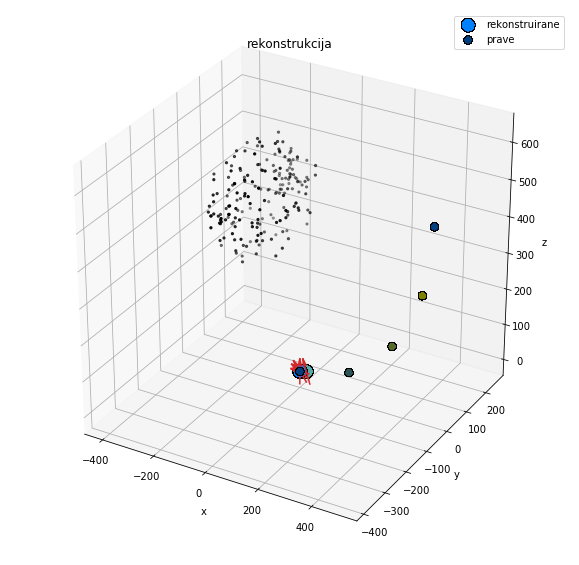

In [226]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs_r, Ys_r, Zs_r, Xd_r, Yd_r, Zd_r, color='C3', length=75, normalize=True, pivot='middle')
ax.scatter(Xs_r, Ys_r, Zs_r, c=c_colors, antialiased=False, depthshade=False, 
           edgecolor='k', linewidth=0.01, s=200, label='rekonstruirane')
ax.scatter(Xs, Ys, Zs, c=c_colors*0.5, antialiased=False, depthshade=False, 
           edgecolor='k', linewidth=0.005, s=75, alpha=1, label='prave')
ax.scatter(XX, YY, ZZ, c='k', marker='.')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('rekonstrukcija')
ax.legend()

#bounding box (equal spect ratio)
X_max = np.max([Xs_r.max(), XX.max()])
Y_min = np.min([Xs_r.min(), XX.min()])
Y_max = np.max([Ys_r.max(), YY.max()])
X_min = np.min([Ys_r.min(), YY.min()])
Z_max = np.max([Zs_r.max(), ZZ.max()])
Z_min = np.min([Zs_r.min(), ZZ.min()])

max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_max+X_min)
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_max+Y_min)
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_max+Z_min)
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

#plt.savefig('rekonstruirane.png', dpi=300)
plt.show()

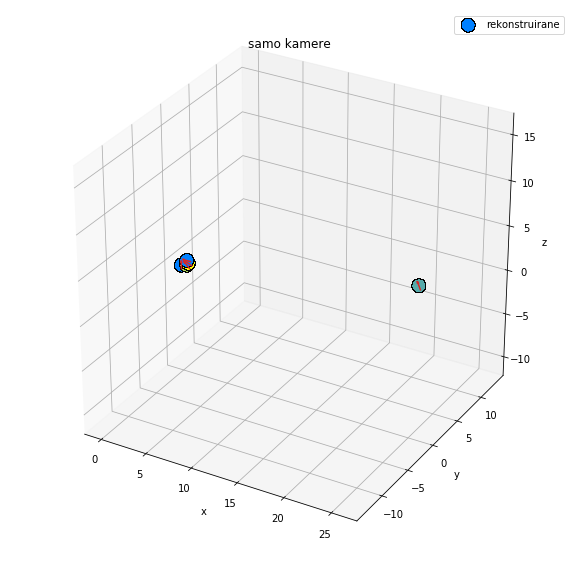

In [227]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(Xs_r, Ys_r, Zs_r, Xd_r, Yd_r, Zd_r, color='C3', length=1, normalize=True, pivot='middle')
ax.scatter(Xs_r, Ys_r, Zs_r, c=c_colors, antialiased=False, depthshade=False, 
           edgecolor='k', linewidth=0.01, s=200, label='rekonstruirane')


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('samo kamere')
ax.legend()

#bounding box (equal spect ratio)
X_max = Xs_r.max()
Y_min = Xs_r.min()
Y_max = Ys_r.max()
X_min = Ys_r.min()
Z_max = Zs_r.max()
Z_min = Zs_r.min()

max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X_max+X_min)
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y_max+Y_min)
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z_max+Z_min)
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

#plt.savefig('rekonstruirane.png', dpi=300)
plt.show()

In [228]:
xyz_r = [project_points(XYZ, Rt, K) for  Rt in P_za_prikaz]

In [229]:
xyz_cv = [cv_project_points(XYZ, Rt, K) for  Rt in P_za_prikaz]

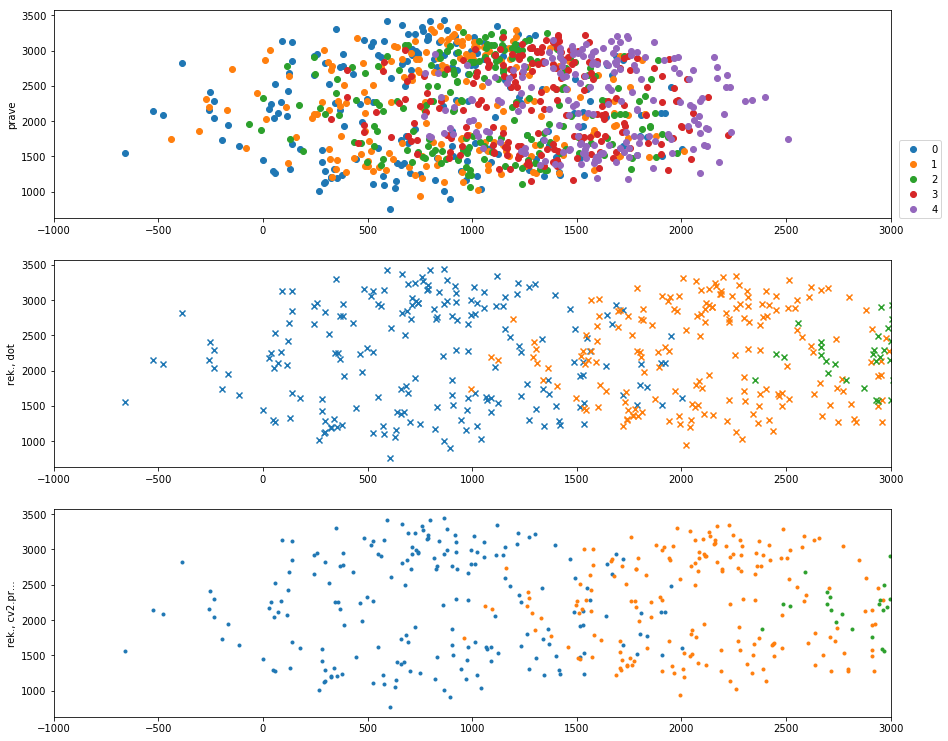

In [233]:
fig, ax = plt.subplots(3, 1, figsize=(15, 13))
for i in range(N_cams):
    ax[0].scatter(xyz[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i))
    ax[0].set_ylabel('prave')
    ax[1].scatter(xyz_r[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i+3), marker='x')
    ax[1].set_ylabel('rek., dot')
    ax[2].scatter(xyz_cv[i][:, 0], xyz[i][:,1], c='C{:d}'.format(i), label='{:d}'.format(i+3), marker='.')
    ax[2].set_ylabel('rek., cv2.pr...')
    ax[0].set_xlim(-1000, 3000);
    ax[1].set_xlim(-1000, 3000);
    ax[2].set_xlim(-1000, 3000);
ax[0].legend(loc=(1.01, 0))
plt.show()

-----------

In [50]:
#test_cloud = pickle.load(open('results\scene_dinoRing_cameradirtest_28-08-15-40.pkl', 'rb'))
#test_cloud = pickle.load(open('results\kip\scene__outliers_removed_kip_pairwise_X_only_PnP_sequential_final_BA_10-08-13-50_25-08-13-03.pkl', 'rb'))
#XYZ = test_cloud.render(cameras=True, q_length=1)